In [74]:
import xarray as xr
import numpy as np
import datetime

def load_data(var, init_times, area=None):
    var_inits = []
    for t0 in init_times:
        yyyymmddhh = t0.strftime('%Y%m%d%H')
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file, chunks={'time': 10})[var]  # Enable lazy loading with Dask
        if area:
            ds = ds.sel(area)
        var_inits.append(ds)
    merged_dataset = xr.concat(var_inits, dim='init_time')
    return merged_dataset.assign_coords(init_time=init_times)

def flip_lon_360_2_180(var_360, lon):
    """
    This function shifts the longitude dimension from [0,360] to [-180,180].
    """
    try:
        var_180 = var_360.assign_coords(lon=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.lon)
    except:
        var_180 = var_360.assign_coords(longitude=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.longitude)

    return var_180

import regionmask

def add_country_mask(ds: xr.Dataset, country: str="Spain") -> xr.Dataset:

    # get countries mask
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

    # create mask variable
    mask = countries.mask_3D(ds)

    # select Spain mask
    var_name = country.lower()
    ds[f"{var_name}_mask"] = mask.isel(region=(mask.names=="Spain")).squeeze().astype(np.int16)

    return ds

def add_land_mask(ds: xr.Dataset) -> xr.Dataset:

    # get land-sea-mask mask
    land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    # create land mask variable
    ds["land_mask"] = land_110.mask_3D(ds).squeeze().astype(np.int16)

    return ds

def from_init_time_to_leadtime(var_init_time, init_time_min, lead_time_range, time_range):
    """
    This function creates a xarray DataArray for a given variable and fills it with values based on the provided time range and lead time range.

    Parameters:
    var_init_time (xarray.DataArray): The initial time data for the variable.
    init_time_min (datetime): The minimum initial time.
    lead_time_range (numpy.ndarray): The range of lead times.
    time_range (pandas.DatetimeIndex): The range of times.

    Returns:
    xarray.DataArray: The created and filled DataArray for the variable.
    """

    # Create a new DataArray for the variable with extra dimensions
    dims = ["lead_time", "time"] + list(var_init_time.dims)[2:]
    coords = {"lead_time": lead_time_range, "time": time_range}
    coords.update({dim: var_init_time.coords[dim] for dim in var_init_time.dims[2:]})
    var_leadtime = xr.DataArray(dims=dims, coords=coords)
    
    # Loop to assign values
    for t in time_range:
        for lt in lead_time_range:
            # Convert the numpy datetime64 object to a Python datetime object
            t_datetime = pd.to_datetime(str(t.values))

            # Subtract the timedelta
            it = t_datetime - datetime.timedelta(hours=int(lt))

            # Assign NaN if the initial time is less than the minimum initial time
            if it < init_time_min:
                var_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan
            else:
                try:
                    # Assign the value from the initial time data for the variable
                    var_leadtime.loc[{"lead_time": lt, "time": t}] = var_init_time.sel(init_time=it, time=t)
                except:
                    # Assign NaN if the value cannot be assigned
                    var_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan

    return var_leadtime

In [54]:
#we want to run our model for different dates
t0_i = datetime.datetime(2022,7,1,0)
t0_f = datetime.datetime(2022,7,25,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [55]:
#load data
t2m_ai = load_data('t2m',init_times)

In [56]:
#read era5 data
dir = '/home/bernatj/Data/my_data/era5/hourly/t2m/t2m-era5-hourly-20227.nc'
t2m_era5 = xr.open_mfdataset(dir).t2m
t2m_era5 = t2m_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 
t2m_era5_max_europe = add_land_mask(flip_lon_360_2_180(t2m_era5[12::24],t2m_era5.lon).sel(time=slice('2022-07-01','2022-07-25'), lat=slice(60,35),lon=slice(-12,25))).load() -273.15
t2m_era5_max_europe_masked = t2m_era5_max_europe.where(t2m_era5_max_europe["land_mask"]==1, drop=True)

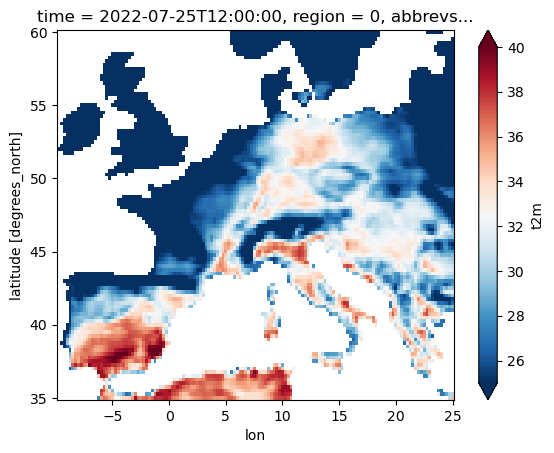

In [5]:
t2m_era5_max_europe_masked[20].plot(cmap='RdBu_r',vmin=25,vmax=40)

In [6]:
t2m_era5_max_france_avg = t2m_era5_max_europe_masked.sel(lat=slice(50,43),lon=slice(-4,8)).mean(['lat','lon'])
t2m_era5_max_germany_avg = t2m_era5_max_europe_masked.sel(lat=slice(55,48),lon=slice(6,16)).mean(['lat','lon'])
t2m_era5_max_uk_avg = t2m_era5_max_europe_masked.sel(lat=slice(58,50),lon=slice(-5,3)).mean(['lat','lon'])
t2m_era5_max_spain_avg = t2m_era5_max_europe_masked.sel(lat=slice(43,35),lon=slice(-9,3)).mean(['lat','lon'])
t2m_era5_max_italy_avg = t2m_era5_max_europe_masked.sel(lat=slice(47,36),lon=slice(8,16)).mean(['lat','lon'])

(15.0, 36.0)

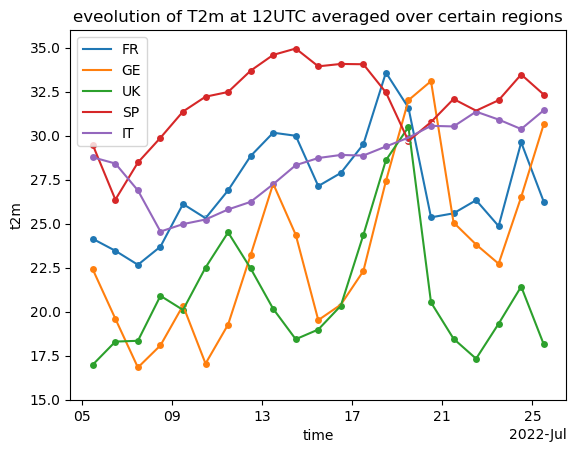

In [7]:
import matplotlib.pyplot as plt
t2m_era5_max_france_avg.plot(label='FR')
t2m_era5_max_france_avg.plot.scatter()
t2m_era5_max_germany_avg.plot(label='GE')
t2m_era5_max_germany_avg.plot.scatter()
t2m_era5_max_uk_avg.plot(label='UK')
t2m_era5_max_uk_avg.plot.scatter()
t2m_era5_max_spain_avg.plot(label='SP')
t2m_era5_max_spain_avg.plot.scatter()
t2m_era5_max_italy_avg.plot(label='IT')
t2m_era5_max_italy_avg.plot.scatter()
plt.legend()
plt.title('eveolution of T2m at 12UTC averaged over certain regions')
plt.ylim(15,36)

# BIAS LEADTIME PLOTS

In [57]:
def transform_to_lead_time(data_array, lead_time_hours=6, max_lead_time_hours=15*24):
    # Create the lead time data array
    lead_times = np.arange(0, max_lead_time_hours, lead_time_hours)
    data_array_leadtime = xr.DataArray(
        dims=("lead_time", "time"),
        coords={"lead_time": lead_times, "time": data_array.time}
    )

    # Loop to assign values
    for t in data_array.time:
        for lt in lead_times:
            it = t - np.timedelta64(int(lt), 'h')
            try:
                data_array_leadtime.loc[{"lead_time": lt, "time": t}] = data_array.sel(init_time=it, time=t)
            except KeyError:
                data_array_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan

    return data_array_leadtime

In [149]:
#first, let's also select regions
t2m_ai_max_europe = add_land_mask(flip_lon_360_2_180(t2m_ai[:,2::4],t2m_ai.lon).sel(time=slice('2022-07-01','2022-07-25'), lat=slice(60,35),lon=slice(-12,25))).load() -273.15
t2m_ai_max_europe_masked = t2m_ai_max_europe.where(t2m_ai_max_europe["land_mask"]==1, drop=True)
t2m_ai_max_france_avg = t2m_ai_max_europe_masked.sel(lat=slice(50,43),lon=slice(-4,8)).mean(['lat','lon'])
t2m_ai_max_iberia_avg = t2m_ai_max_europe_masked.sel(lat=slice(44,36),lon=slice(-10,3)).mean(['lat','lon'])

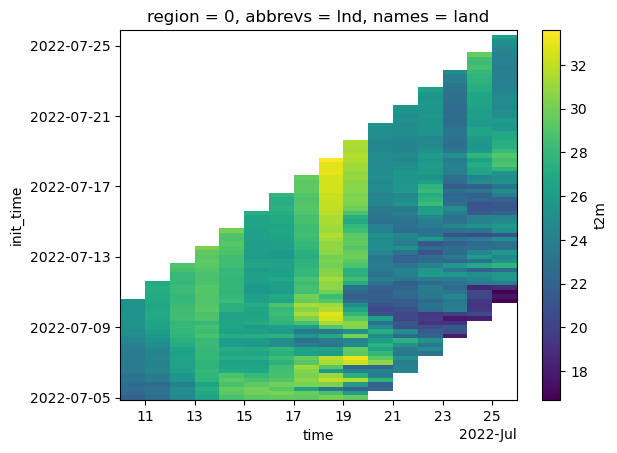

In [10]:
t2m_ai_max_france_avg.plot()

In [60]:
t2m_ai_max_france_avg_lt = transform_to_lead_time(t2m_ai_max_france_avg)
t2m_ai_max_iberia_avg_lt = transform_to_lead_time(t2m_ai_max_iberia_avg)

In [165]:
bias_france_lt = t2m_ai_max_france_avg_lt - t2m_era5_max_france_avg
bias_iberia_lt = t2m_ai_max_iberia_avg_lt - t2m_ai_max_iberia_avg_lt[0]

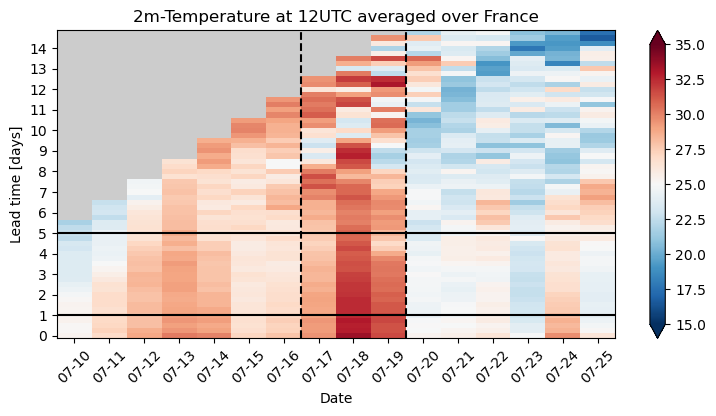

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_data(data, vmin, vmax, title='BIAS mean 2m-Temperature at 12UTC [France]'):
    # Create a new figure with desired size
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.set_facecolor('0.8')

    # Plot the data
    data.plot(ax=ax, cmap='RdBu_r', vmax=vmax, vmin=vmin, extend='both')

    # Add vertical lines at specified dates
    aug_1 = pd.to_datetime('2022-07-17')
    aug_7 = pd.to_datetime('2022-07-20')
    ax.axvline(x=aug_1, color='k', linestyle='--')
    ax.axvline(x=aug_7, color='k', linestyle='--')

    # Add horizontal lines at specified lead times
    ax.axhline(y=1*24, color='k', linestyle='-')
    ax.axhline(y=5*24, color='k', linestyle='-')

    # Set the y-axis tick positions to the middle of the raster boxes
    ax.set_yticks(data[::4].lead_time)
    labels = [(value.values / 24) for value in data[::4].lead_time]
    ax.set_yticklabels(int(label) for label in labels)

    # Set the x-axis tick positions to the middle of the raster boxes
    ax.set_xticks(data.time)
    ax.set_xticklabels(data.time.dt.strftime('%m-%d').values)

    # Rotate the tick labels for better readability
    plt.xticks(rotation=45)

    # Add labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Lead time [days]')
    ax.set_title(title)

    plt.show()

plot_data(data=t2m_ai_max_france_avg_lt , vmin=15, vmax=35, title='2m-Temperature at 12UTC averaged over France')



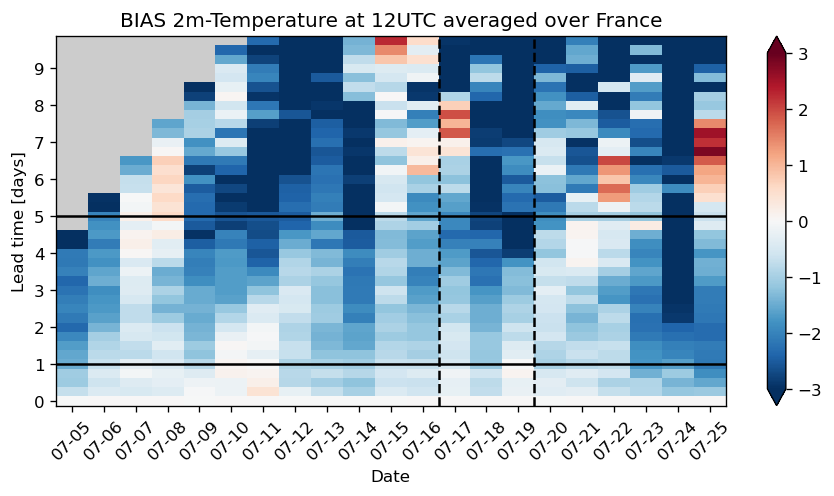

In [168]:
plot_data(data=bias_france_lt[0:10*4] , vmin=-3, vmax=3, title='BIAS 2m-Temperature at 12UTC averaged over France')

In [169]:
#same but using leadtime to produce the spread
lead_time_slice=slice(1*24,5*24)
ens_mean = t2m_ai_max_france_avg_lt.sel(lead_time=lead_time_slice).mean('lead_time')  
ens_max = t2m_ai_max_france_avg_lt.sel(lead_time=lead_time_slice).max('lead_time') 
ens_min = t2m_ai_max_france_avg_lt.sel(lead_time=lead_time_slice).min('lead_time') 
ens_p90 = t2m_ai_max_france_avg_lt.sel(lead_time=lead_time_slice).quantile(0.75,'lead_time') 
ens_p10 = t2m_ai_max_france_avg_lt.sel(lead_time=lead_time_slice).quantile(0.25,'lead_time') 

/home/bernatj/miniconda3/envs/bayesevt_ai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'France mean 2m-Temperature at 12UTC [43-50$^{\\circ}$N, 4$^{\\circ}$W-8$^{\\circ}$E]')

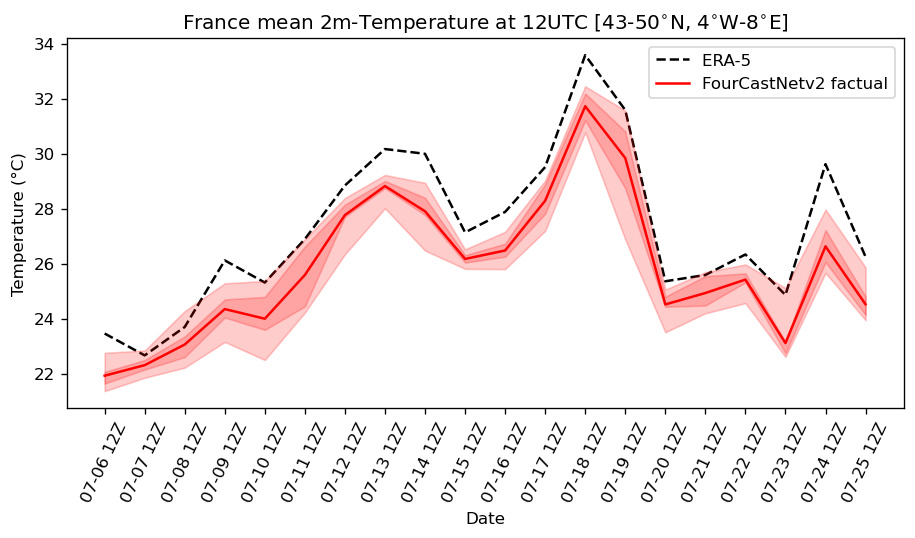

In [173]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(9, 4))

# Plot t2m_era5_max_iberia_avg
t2m_ai_max_france_avg_lt[0,5::].plot(ax=ax, label='ERA-5 ', color='k', linestyle='--')

# Plot t2m_ai_max_iberia_avg
ens_mean[5::].plot(ax=ax, label='FourCastNetv2 factual', color='red', linestyle='-', zorder=102)
ax.fill_between(ens_min['time'][5::], ens_min[5::], ens_max[5::], color='red', alpha=0.2, zorder=101)
ax.fill_between(ens_min['time'][5::], ens_p10[5::], ens_p90[5::], color='red', alpha=0.2, zorder=100)

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
#ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(t2m_ai_max_france_avg_lt[:,5::].time[:])
ax.set_xticklabels(t2m_ai_max_france_avg_lt[:,5::].time[:].dt.strftime('%m-%d %HZ').values)
# Rotate the tick labels for better readability
plt.xticks(rotation=65)

# Add legend
ax.legend(fontsize=10)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('France mean 2m-Temperature at 12UTC [43-50$^{\circ}$N, 4$^{\circ}$W-8$^{\circ}$E]')

#plt.savefig('time_evolution_time_2018HW_Iberia_FourCastNet_wrt_ERA5_leadtime_1d-5d.pdf',bbox_inches='tight')
#plt.savefig('time_evolution_time_2018HW_Iberia_FourCastNet_wrt_ERA5_leadtime_1d-5d.png')

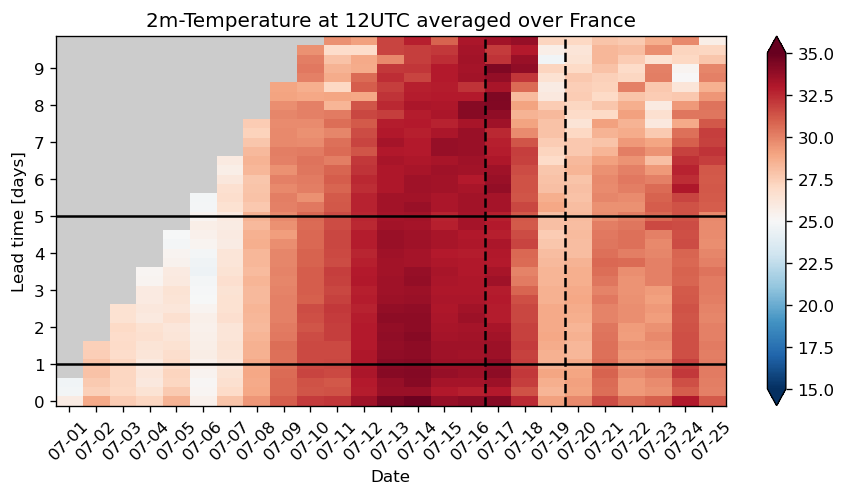

In [163]:
plot_data(data=t2m_ai_max_iberia_avg_lt , vmin=15, vmax=35, title='2m-Temperature at 12UTC averaged over France')


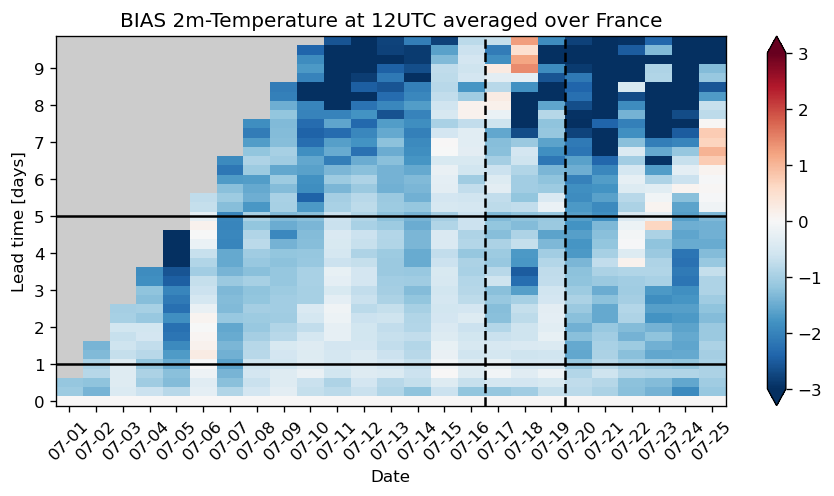

In [166]:
plot_data(data=bias_iberia_lt , vmin=-3, vmax=3, title='BIAS 2m-Temperature at 12UTC averaged over France')

In [161]:
#same but using leadtime to produce the spread
lead_time_slice=slice(1*24,5*24)
ens_mean = t2m_ai_max_iberia_avg_lt.sel(lead_time=lead_time_slice).mean('lead_time')  
ens_max = t2m_ai_max_iberia_avg_lt.sel(lead_time=lead_time_slice).max('lead_time') 
ens_min = t2m_ai_max_iberia_avg_lt.sel(lead_time=lead_time_slice).min('lead_time') 
ens_p90 = t2m_ai_max_iberia_avg_lt.sel(lead_time=lead_time_slice).quantile(0.75,'lead_time') 
ens_p10 = t2m_ai_max_iberia_avg_lt.sel(lead_time=lead_time_slice).quantile(0.25,'lead_time') 

/home/bernatj/miniconda3/envs/bayesevt_ai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'Iberian mean 2m-Temperature at 12UTC [36-43$^{\\circ}$N, 9$^{\\circ}$W-3$^{\\circ}$E]')

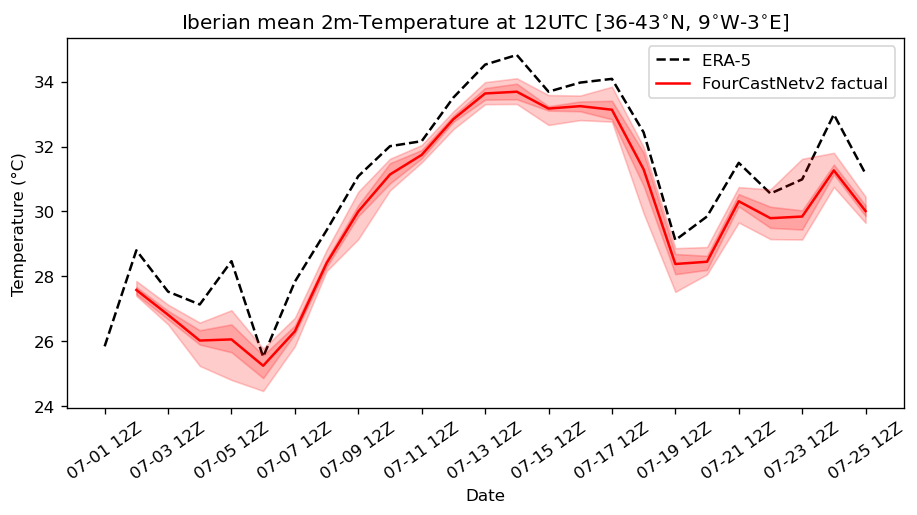

In [162]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(9, 4))

# Plot t2m_era5_max_iberia_avg
t2m_ai_max_iberia_avg_lt[0,:].plot(ax=ax, label='ERA-5 ', color='k', linestyle='--')

# Plot t2m_ai_max_iberia_avg
ens_mean[:].plot(ax=ax, label='FourCastNetv2 factual', color='red', linestyle='-', zorder=102)
ax.fill_between(ens_min['time'][:], ens_min[:], ens_max[:], color='red', alpha=0.2, zorder=101)
ax.fill_between(ens_min['time'][:], ens_p10[:], ens_p90[:], color='red', alpha=0.2, zorder=100)

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
#ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(t2m_ai_max_iberia_avg_lt.time[::2])
ax.set_xticklabels(t2m_ai_max_iberia_avg_lt.time[::2].dt.strftime('%m-%d %HZ').values)
# Rotate the tick labels for better readability
plt.xticks(rotation=35)

# Add legend
ax.legend(fontsize=10)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Iberian mean 2m-Temperature at 12UTC [36-43$^{\circ}$N, 9$^{\circ}$W-3$^{\circ}$E]')

#plt.savefig('time_evolution_time_2018HW_Iberia_FourCastNet_wrt_ERA5_leadtime_1d-5d.pdf',bbox_inches='tight')
#plt.savefig('time_evolution_time_2018HW_Iberia_FourCastNet_wrt_ERA5_leadtime_1d-5d.png')

In [70]:
def load_data_deltas(var, init_times, models):
    var_inits_model = []
    for model in models:
        print(model)
        var_inits = []
        for t0 in init_times:
            yyyymmddhh = t0.strftime('%Y%m%d%H')    
            file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
            ds = xr.open_dataset(file)[var]
            var_inits.append(ds)
        var_inits_model.append(xr.concat(var_inits, dim='init_time'))
    merged_dataset = xr.concat(var_inits_model, dim='model')
    return merged_dataset.assign_coords(init_time=init_times,model=models)

t2m_pgw = load_data_deltas('t2m',init_times,['multimodel']).squeeze()

multimodel


In [152]:
t2m_ai_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_ai[:,2::4], t2m_ai.lon).sel(lat=slice(50,30), lon=slice(-12,9))) -273.15
t2m_ai_max_iberia_masked = t2m_ai_max_iberia.where(t2m_ai_max_iberia["land_mask"]==1, drop=True)


#average over iberia:
t2m_ai_max_iberia_avg = t2m_ai_max_iberia_masked.sel(lat=slice(44,36),lon=slice(-10,3)).mean(['lon','lat'])

In [153]:
t2m_pgw_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_pgw[:,2::4], t2m_pgw.lon).sel(lat=slice(50,30), lon=slice(-12,9))) -273.15
t2m_pgw_max_iberia_masked = t2m_pgw_max_iberia.where(t2m_pgw_max_iberia["land_mask"]==1, drop=True)

#average over iberia:
t2m_pgw_max_iberia_avg = t2m_pgw_max_iberia_masked.sel(lat=slice(44,36),lon=slice(-10,3)).mean(['lon','lat'])

In [154]:
#from init time to lead time
time_range = t2m_pgw.time.sel(time=slice('2022-07-01','2022-07-25'))
init_time_min = datetime.datetime(2022, 7, 1, 0)
lead_time_range = np.arange(0,10*24,6)

t2m_pgw_max_iberia_avg_lt = from_init_time_to_leadtime(t2m_pgw_max_iberia_avg, init_time_min, lead_time_range, time_range)[:,2::4]
#t2m_pgw_max_iberia_lt  = from_init_time_to_leadtime(t2m_pgw_max_iberia, init_time_min, lead_time_range, time_range)[:,2::4]

t2m_ai_max_iberia_avg_lt = from_init_time_to_leadtime(t2m_ai_max_iberia_avg, init_time_min, lead_time_range, time_range)[:,2::4]
#t2m_ai_max_iberia_lt  = from_init_time_to_leadtime(t2m_ai_max_iberia, init_time_min, lead_time_range, time_range)[:,2::4]

In [159]:
t2m_ai_max_iberia_avg_lt_2 = transform_to_lead_time(t2m_ai_max_iberia_avg)
t2m_pgw_max_iberia_avg_lt_2 = transform_to_lead_time(t2m_pgw_max_iberia_avg)

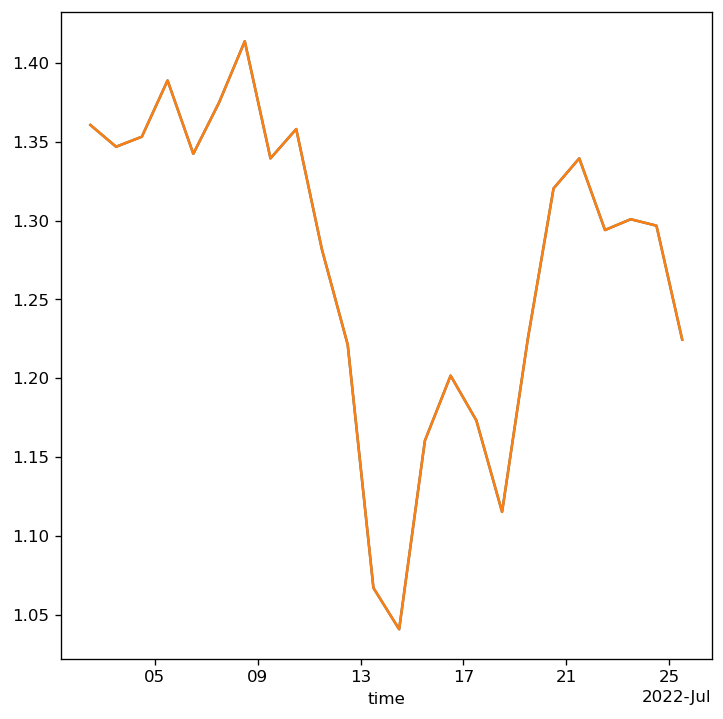

In [160]:
lead_time_slice=slice(1*24,5*24)
a = t2m_ai_max_iberia_avg_lt.sel(lead_time=lead_time_slice).mean('lead_time')  
b = t2m_pgw_max_iberia_avg_lt.sel(lead_time=lead_time_slice).mean('lead_time')
(a - b).plot()
a1 = t2m_ai_max_iberia_avg_lt_2.sel(lead_time=lead_time_slice).mean('lead_time')  
b1 = t2m_pgw_max_iberia_avg_lt_2.sel(lead_time=lead_time_slice).mean('lead_time')
(a1 - b).plot()

In [135]:
diff_pgw_t2m_iberia = t2m_ai_max_iberia_avg_lt - t2m_pgw_max_iberia_avg_lt

Text(0.5, 1.0, 'Iberian mean 2m-Temperature at 12UTC [36-44$^{\\circ}$N, 10$^{\\circ}$W-3$^{\\circ}$E]')

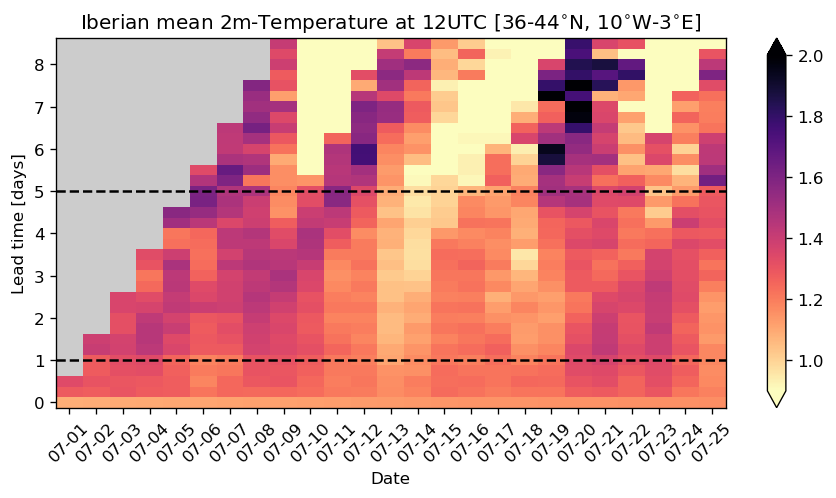

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_facecolor('0.8')
# Plot t2m_era5_max_iberia_avg
#gist_heat_r
diff_pgw_t2m_iberia[0:35,:].plot(ax=ax, cmap='magma_r', vmax=1, vmin=2, extend='both')

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2022-08-01')
aug_7 = pd.to_datetime('2022-08-07')

# Add a filled background between the vertical lines
ax.axvline(x=aug_1, color='k', linestyle='--')
ax.axvline(x=aug_7, color='k', linestyle='--')

ax.axhline(y=1*24, color='k', linestyle='--')
ax.axhline(y=5*24, color='k', linestyle='--')


# Set the x-axis tick positions to the middle of the raster boxes
ax.set_yticks(diff_pgw_t2m_iberia[0:35:4,0:12].lead_time)
# Set the tick labels to the desired dates
labels = [(value.values/24) for value in diff_pgw_t2m_iberia[0:35:4,0:12].lead_time]
ax.set_yticklabels(int(label) for label in labels)

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(diff_pgw_t2m_iberia[:,:].time)
# Set the tick labels to the desired dates
ax.set_xticklabels(diff_pgw_t2m_iberia[:,:].time.dt.strftime('%m-%d').values)

# Rotate the tick labels for better readability
plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Lead time [days]')
ax.set_title('Iberian mean 2m-Temperature at 12UTC [36-44$^{\circ}$N, 10$^{\circ}$W-3$^{\circ}$E]')

#plt.savefig('Atributtion_leadtime_vs_time_2018HW_Iberia_FourCastNet_mmm_pgw.pdf',bbox_inches='tight')
#plt.savefig('Atributtion_leadtime_vs_time_2018HW_Iberia_FourCastNet_mmm_pgw_v2.png')

In [137]:
#calculate bias:
lead_time_slice=slice(1*24,5*24)
ens_mean_iberia = t2m_pgw_max_iberia_lt.sel(lead_time=lead_time_slice).mean('lead_time')
ens_mean_iberia_fac = t2m_ai_max_iberia_lt.sel(lead_time=lead_time_slice).mean('lead_time')  

t2m_ai_pgw_iberia = (ens_mean_iberia_fac - ens_mean_iberia).load()

In [ ]:
t2m_ai_max_iberia_lt

In [118]:
t2m_ai_pgw_iberia

<xarray.DataArray (time: 25, lat: 65, lon: 81)> Size: 1MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[1.06480916, 1.07161458, 1.07064819, ..., 1.20801799,
         1.2003479 , 1.20451864],
        [1.07493083, 1.06918335, 1.06680298, ..., 1.2148641 ,
         1.21236165, 1.20839437],
        [1.07578532, 1.07263184, 1.06890869, ..., 1.21927897,
         1.20821126, 1.21056112],
...
        [0.92563584, 0.93549302, 0.93234253, ..., 1.09397798,
         1.07501759, 1.06649421],
        [0.92227891, 0.92665369, 0.92933026, ..., 1.05922385,
         1.05559046, 1.05100923],
        [0.91862578, 0.91889146, 0.92255357, ..., 1.04310698,
         1.04004804, 1.04082893]],

       [[0.97107472, 0.97407083, 0.97485172, ..., 1.03660853,
         1.03198242, 1.02075554],
        [0.96707153, 0.96717924, 0.96516329, ..., 1.0316216 ,
         1.02022238, 1.01782047],
        [0.95425954, 0.95420389, 0.95473346, ..., 1.02629897,
         1.01884191, 1.0108858 ],
        ...,
        [0.78019086, 0.78219964, 0.78372192, ..., 1.14724013,
         1.13747451, 1.13208367],
        [0.77073221, 0.77494004, 0.77598482, ..., 1.12212058,
         1.11991075, 1.11407471],
        [0.75937787, 0.76259478, 0.76228243, ..., 1.09997918,
         1.09949628, 1.10212618]]])
Coordinates:
  * time     (time) datetime64[ns] 200B 2022-07-01T12:00:00 ... 2022-07-25T12...
  * lat      (lat) float64 520B 50.0 49.75 49.5 49.25 ... 34.75 34.5 34.25 34.0
  * lon      (lon) float64 648B -15.0 -14.75 -14.5 -14.25 ... 4.25 4.5 4.75 5.0

In [147]:
#significance
from scipy import stats
sample1= t2m_pgw_max_iberia_lt.sel(lead_time=lead_time_slice).values
sample2= t2m_ai_max_iberia_lt.sel(lead_time=lead_time_slice).values

_, p_value = stats.ttest_ind(sample1, sample2, axis=0)

/tmp/ipykernel_1268658/1465345608.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


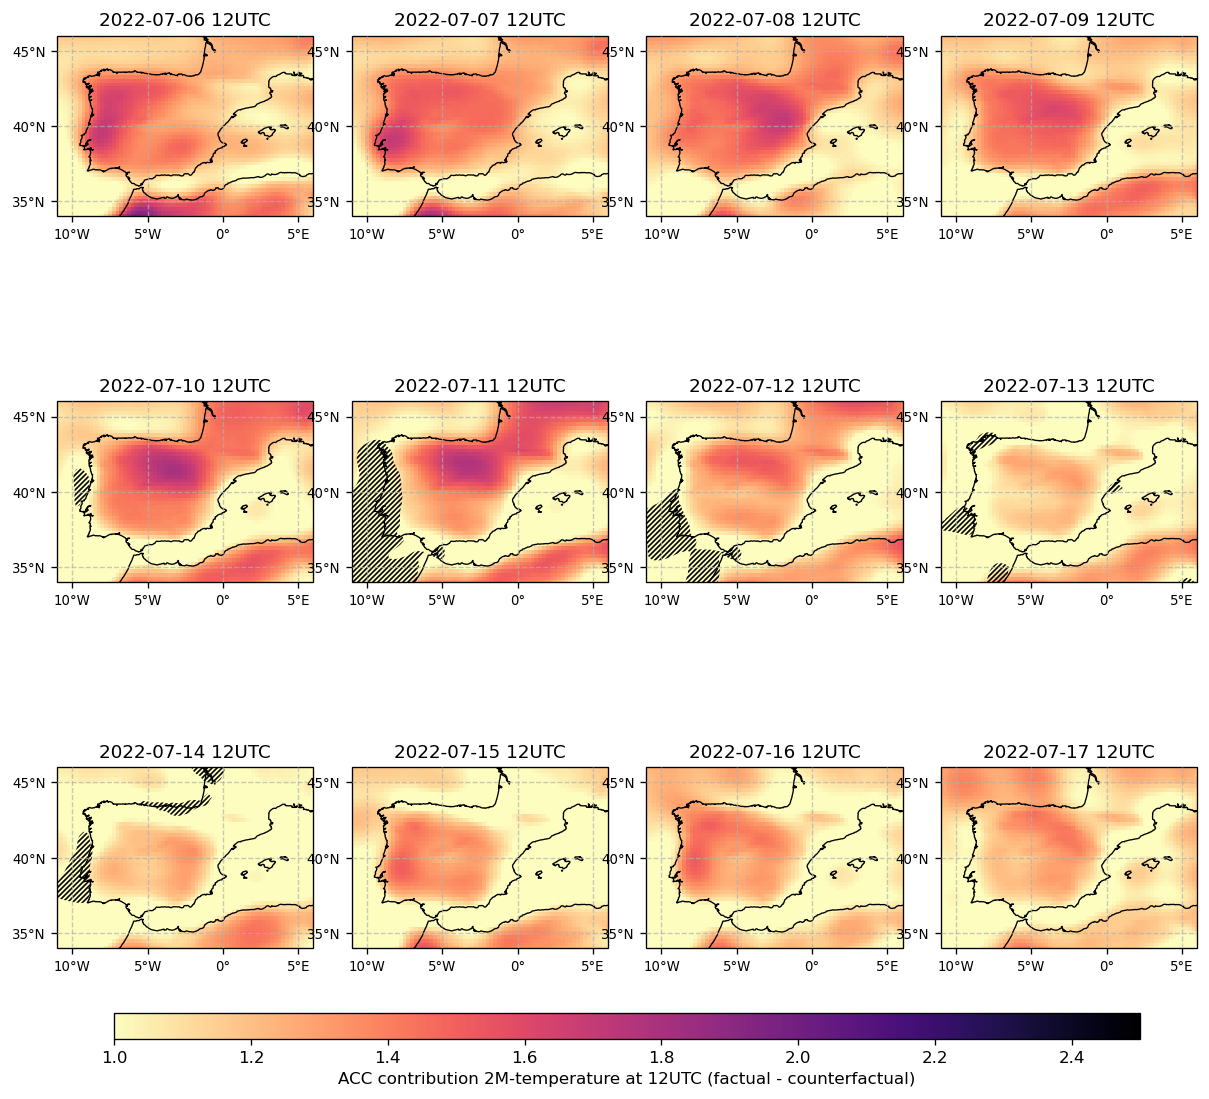

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= t2m_ai_pgw_iberia[5:20] 
p_val = p_value[5:20]
# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

#lev = np.arange(-3,3.1,0.25)
lev = np.arange(16,42.1,1)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):


    ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

    ax.set_xticks(nLons, crs=ccrs.PlateCarree())
    ax.set_yticks(nLats, crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim([34, 46])
    ax.set_xlim([-11, 6])
    
    ax.set_facecolor('0.9')
    ax.coastlines(lw=0.8, color='k')  
    ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.set_aspect(1)

    # Explicitly pass the ax parameter to contourf
    #h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 
    h = ax.pcolormesh(lon, lat, data[i], cmap='magma_r', vmax=2.5, vmin=1)
    p = ax.contourf(lon, lat, p_val[i], colors='none', levels=[0.01,1], hatches=['////////',''])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.15, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(h, ax=axes, label='ACC contribution 2M-temperature at 12UTC (factual - counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC FourcastNet (Factual - Counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
#plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual-leadtime_1-5d.pdf',bbox_inches='tight')

/tmp/ipykernel_1268658/1769907703.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


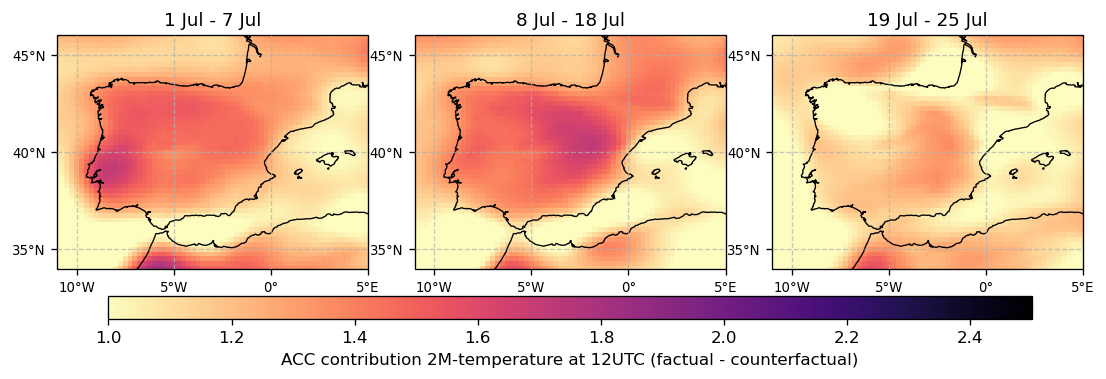

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= t2m_ai_pgw_iberia[2:18] 
p_val = p_value[2:18]
# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(9,5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

#lev = np.arange(-3,3.1,0.25)
lev = np.arange(16,42.1,1)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    ax.set_xticks(nLons, crs=ccrs.PlateCarree())
    ax.set_yticks(nLats, crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim([34, 46])
    ax.set_xlim([-11, 5])
    
    ax.set_facecolor('0.9')
    ax.coastlines(lw=0.8, color='k')  
    ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.set_aspect(1)

    
#axes[0].set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

# Explicitly pass the ax parameter to contourf
#h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 

axes[0].set_title('1 Jul - 7 Jul', fontsize=11)
data= t2m_ai_pgw_iberia.sel(time=slice('2022-07-07','2022-07-07')).mean('time') 
#p_val = p_value[:18]
plot1 = axes[0].pcolormesh(lon, lat, data, cmap='magma_r', vmax=2.5, vmin=1)

axes[1].set_title('8 Jul - 18 Jul', fontsize=11)
data= t2m_ai_pgw_iberia.sel(time=slice('2022-07-08','2022-07-08')).mean('time') 
plot2 = axes[1].pcolormesh(lon, lat, data, cmap='magma_r', vmax=2.5, vmin=1)

axes[2].set_title('19 Jul - 25 Jul', fontsize=11)
data= t2m_ai_pgw_iberia.sel(time=slice('2022-07-18','2022-07-18')).mean('time') 
plot3 = axes[2].pcolormesh(lon, lat, data, cmap='magma_r', vmax=2.5, vmin=1)

#p = ax.contourf(lon, lat, p_val[i], colors='none', levels=[0.01,1], hatches=['////////',''])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.15, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(plot2, ax=axes, label='ACC contribution 2M-temperature at 12UTC (factual - counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC FourcastNet (Factual - Counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual-leadtime_1-5d_3periods.pdf',bbox_inches='tight')